In [ ]:
!pip install pandas matplotlib seaborn scipy scikit-learn jinja2

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11


In [38]:
# Cargar datos locales y tipificar

DATA_DIR = Path("../data")
matches_path = DATA_DIR / "WorldCupMatches.csv"

df = pd.read_csv(matches_path)
# Limpieza mínima y tipificación
for col in ["Attendance", "Home Team Goals", "Away Team Goals", "Half-time Home Goals", "Half-time Away Goals"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# Variables derivadas (continuas)
avg_year = df.groupby("Year", dropna=True)["Attendance"].mean().rename("AvgAttendanceByYear")
df = df.merge(avg_year, on="Year", how="left")

avg_stage = df.groupby("Stage")["Attendance"].mean().rename("AvgAttendanceByStage")
df["AvgAttendanceByStage"] = df["Stage"].map(avg_stage)


# Selección de variables del proyecto
vars_continuas = ["Attendance", "AvgAttendanceByYear", "AvgAttendanceByStage"]
vars_discretas = ["Year", "Stage", "City"]
vars_extra = ["Stadium", "Home Team Name", "Away Team Name", "Home Team Goals", "Away Team Goals", "Half-time Home Goals", "Half-time Away Goals"]

cols_finales = list(dict.fromkeys(vars_continuas + vars_discretas + vars_extra))
df_clean = df[cols_finales].copy()
df_clean["Total_Goals"] = df_clean["Home Team Goals"] + df_clean["Away Team Goals"]
# Filtrado básico: filas con año, etapa, ciudad y asistencia válidas
df_clean = df_clean.dropna(subset=["Year", "Stage", "City", "Attendance"])


# Análisis Exploratorio de Datos: Asistencia en la Copa del Mundo FIFA

## Problema de Investigación
**¿Qué factores influyen en la asistencia de público a los partidos de la Copa del Mundo?**

## Contexto
La asistencia a los estadios refleja el interés por el fútbol y la influencia de factores sociales, culturales y económicos. Este análisis busca identificar patrones en:
- Etapas del torneo (fase de grupos, eliminatorias, finales)
- Ciudades y estadios sede
- Evolución temporal de la asistencia
- Relación con resultados deportivos


## 1. Descripción de Variables

### Variables Continuas (Cuantitativas)
- **Attendance**: Número de asistentes al partido (variable objetivo)
- **AvgAttendanceByYear**: Promedio de asistencia por año (variable derivada)
- **AvgAttendanceByStage**: Promedio de asistencia por fase del torneo (variable derivada)

### Variables Discretas
- **Year**: Año de la Copa del Mundo (1930-2014)
- **Stage**: Fase del torneo (grupos, octavos, cuartos, semifinal, final)
- **City**: Ciudad sede del partido

### Variables Adicionales
- **Stadium**, **Home/Away Team Name**, **Goals**: Variables contextuales para análisis complementario


In [45]:
df = df_clean.copy()

tabla_vars = pd.DataFrame({
    "Variable": df_clean.columns,
    "Tipo": df_clean.dtypes.astype(str),
    "No Nulos": df_clean.count(),
    "Valores Únicos": df_clean.nunique(),
    "% Nulos": (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
})

display(tabla_vars.style.background_gradient(subset=['% Nulos'], cmap='Reds'))


,Variable,Tipo,No Nulos,Valores Únicos,% Nulos
Attendance,Attendance,float64,850,622,0.000000
AvgAttendanceByYear,AvgAttendanceByYear,float64,850,20,0.000000
AvgAttendanceByStage,AvgAttendanceByStage,float64,850,23,0.000000
Year,Year,Int64,850,20,0.000000
Stage,Stage,object,850,23,0.000000
City,City,object,850,151,0.000000
Stadium,Stadium,object,850,181,0.000000
Home Team Name,Home Team Name,object,850,78,0.000000
Away Team Name,Away Team Name,object,850,83,0.000000
Home Team Goals,Home Team Goals,float64,850,11,0.000000


In [46]:
# Estadísticos de variables continuas
stats_continuas = df_clean[vars_continuas].describe().T
stats_continuas['CV'] = (stats_continuas['std'] / stats_continuas['mean'] * 100).round(2)
stats_continuas['IQR'] = stats_continuas['75%'] - stats_continuas['25%']

display(stats_continuas.style.format("{:.2f}").background_gradient(cmap='Blues'))


,count,mean,std,min,25%,50%,75%,max,CV,IQR
Attendance,850.00,45164.80,23485.25,2000.00,30000.00,41579.50,61374.50,173850.00,52.00,31374.50
AvgAttendanceByYear,850.00,45164.80,11007.96,20872.22,40678.71,47511.18,50124.22,68991.12,24.37,9445.51
AvgAttendanceByStage,850.00,45164.80,10543.76,16120.33,41664.06,45675.92,51367.87,76383.65,23.35,9703.80


### Se puede observar la volatilidad de la variable "Attendance" y como se ha reducio la disperción en las otras dos variables debido a que son derivadas de la misma variable

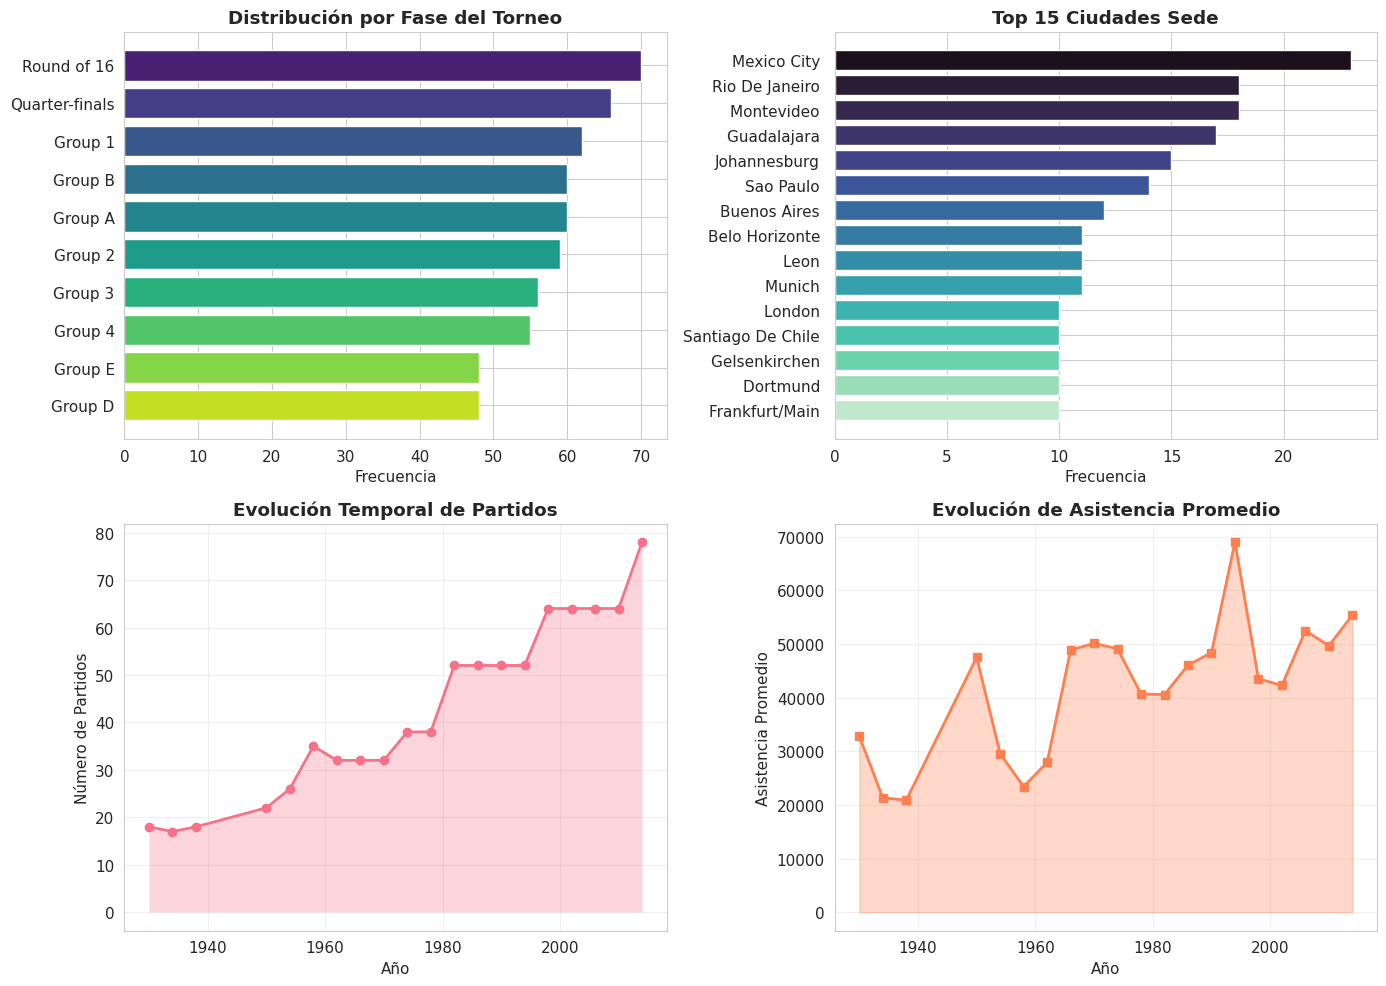

In [47]:
# Frecuencias de variables discretas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Stage
stage_counts = df_clean["Stage"].value_counts().head(10)
axes[0, 0].barh(range(len(stage_counts)), stage_counts.values, color=sns.color_palette("viridis", len(stage_counts)))
axes[0, 0].set_yticks(range(len(stage_counts)))
axes[0, 0].set_yticklabels(stage_counts.index)
axes[0, 0].set_xlabel("Frecuencia")
axes[0, 0].set_title("Distribución por Fase del Torneo", fontweight='bold')
axes[0, 0].invert_yaxis()

# City (Top 15)
city_counts = df_clean["City"].value_counts().head(15)
axes[0, 1].barh(range(len(city_counts)), city_counts.values, color=sns.color_palette("mako", len(city_counts)))
axes[0, 1].set_yticks(range(len(city_counts)))
axes[0, 1].set_yticklabels(city_counts.index)
axes[0, 1].set_xlabel("Frecuencia")
axes[0, 1].set_title("Top 15 Ciudades Sede", fontweight='bold')
axes[0, 1].invert_yaxis()

# Year
year_counts = df_clean["Year"].value_counts().sort_index()
axes[1, 0].plot(year_counts.index, year_counts.values, marker='o', linewidth=2, markersize=6)
axes[1, 0].fill_between(year_counts.index, year_counts.values, alpha=0.3)
axes[1, 0].set_xlabel("Año")
axes[1, 0].set_ylabel("Número de Partidos")
axes[1, 0].set_title("Evolución Temporal de Partidos", fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
# Asistencia promedio por año
year_att = df_clean.groupby("Year")["Attendance"].mean()
axes[1, 1].plot(year_att.index, year_att.values, marker='s', linewidth=2, markersize=6, color='coral')
axes[1, 1].fill_between(year_att.index, year_att.values, alpha=0.3, color='coral')
axes[1, 1].set_xlabel("Año")
axes[1, 1].set_ylabel("Asistencia Promedio")
axes[1, 1].set_title("Evolución de Asistencia Promedio", fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### -Se observa una tendencia algo obvia en la cantidad de partidos por fase del torne
### -Se observa que las ciudades que más asistencia han en un partido del mundial se encuentran en latinoamérica en países como México, Brasil, Argentina y Uruguay
### -La cantidad de partidos no ha sido la misma en todos los torneas, podemos ver como en los años 40 se jugaban 20 partidos y hoy en día se jugan hasta casi 80 partidos
### -La asistencia promedio por torneo ha fluctuado con el pasar de los años, se observa que su pico más alto se logró en los años 90 como casi 70000 espectadores

# Analisis univariado variable "Attendance"

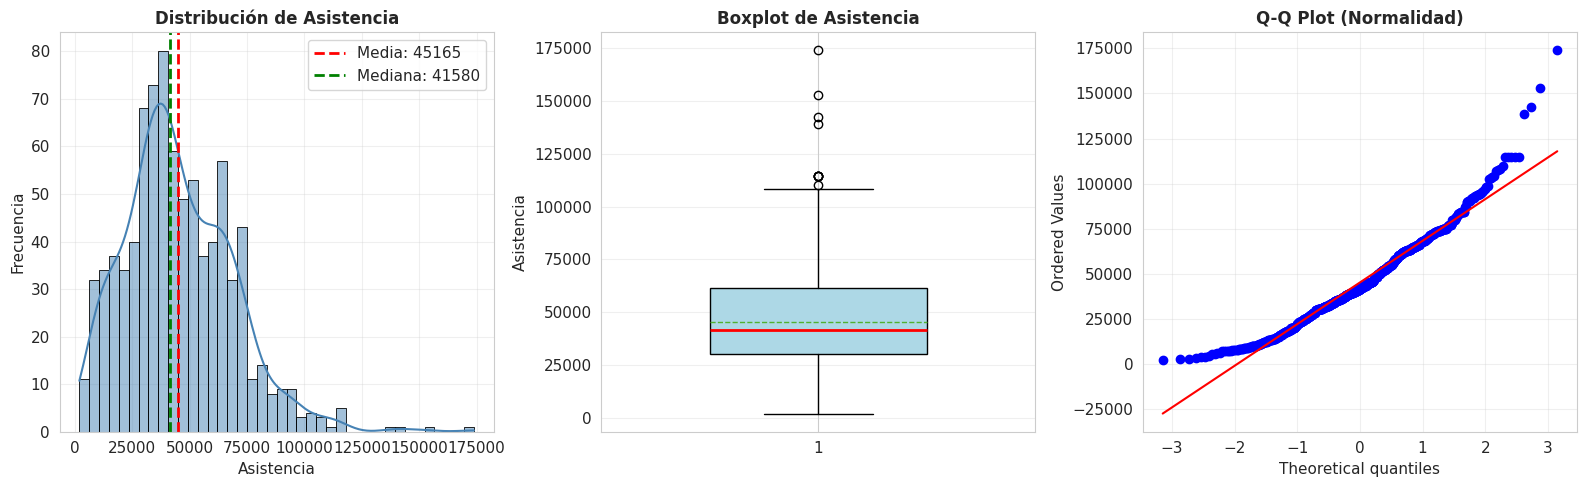

Test de Shapiro-Wilk: p-value = 0.000000
✓ La distribución NO es normal (α=0.05)


In [48]:
# Análisis univariado detallado de Attendance
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Histograma con KDE
sns.histplot(df_clean["Attendance"], bins=40, kde=True, ax=axes[0], color='steelblue', edgecolor='black')
axes[0].axvline(df_clean["Attendance"].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df_clean["Attendance"].mean():.0f}')
axes[0].axvline(df_clean["Attendance"].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df_clean["Attendance"].median():.0f}')
axes[0].set_xlabel("Asistencia")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de Asistencia", fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
box = axes[1].boxplot(df_clean["Attendance"].dropna(), vert=True, patch_artist=True, 
                       widths=0.5, showmeans=True, meanline=True)
box['boxes'][0].set_facecolor('lightblue')
box['medians'][0].set_color('red')
box['medians'][0].set_linewidth(2)
axes[1].set_ylabel("Asistencia")
axes[1].set_title("Boxplot de Asistencia", fontweight='bold', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')

# QQ-plot para normalidad
stats.probplot(df_clean["Attendance"].dropna(), dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot (Normalidad)", fontweight='bold', fontsize=12)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test de normalidad
_, p_value = stats.shapiro(df_clean["Attendance"].sample(min(5000, len(df_clean))))
print(f"Test de Shapiro-Wilk: p-value = {p_value:.6f}")
print(f"{'✓' if p_value < 0.05 else '✗'} La distribución {'NO' if p_value < 0.05 else 'SÍ'} es normal (α=0.05)")


### Con ayuda de estas gráficas podemos concluir lo siguiente:
##### - La distribución de los datos es asimétrica, la cola de la distribución se extiende mucho más a la dercha
##### - Hay numerosos outliers en los extremos que hace que la distribución no sea normal
##### - Los outliers de cardinalidad alta hacen que a media si corra hacia la derecha mostrando un sesgo positivo en la distribución

/tmp/ipykernel_71498/590477870.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean[df_clean["Stage"].isin(stage_order)],
/tmp/ipykernel_71498/590477870.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_71498/590477870.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_clean[df_clean["Stage"].isin(top6_stages)],
/tmp/ipykernel_71498/590477870.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_x

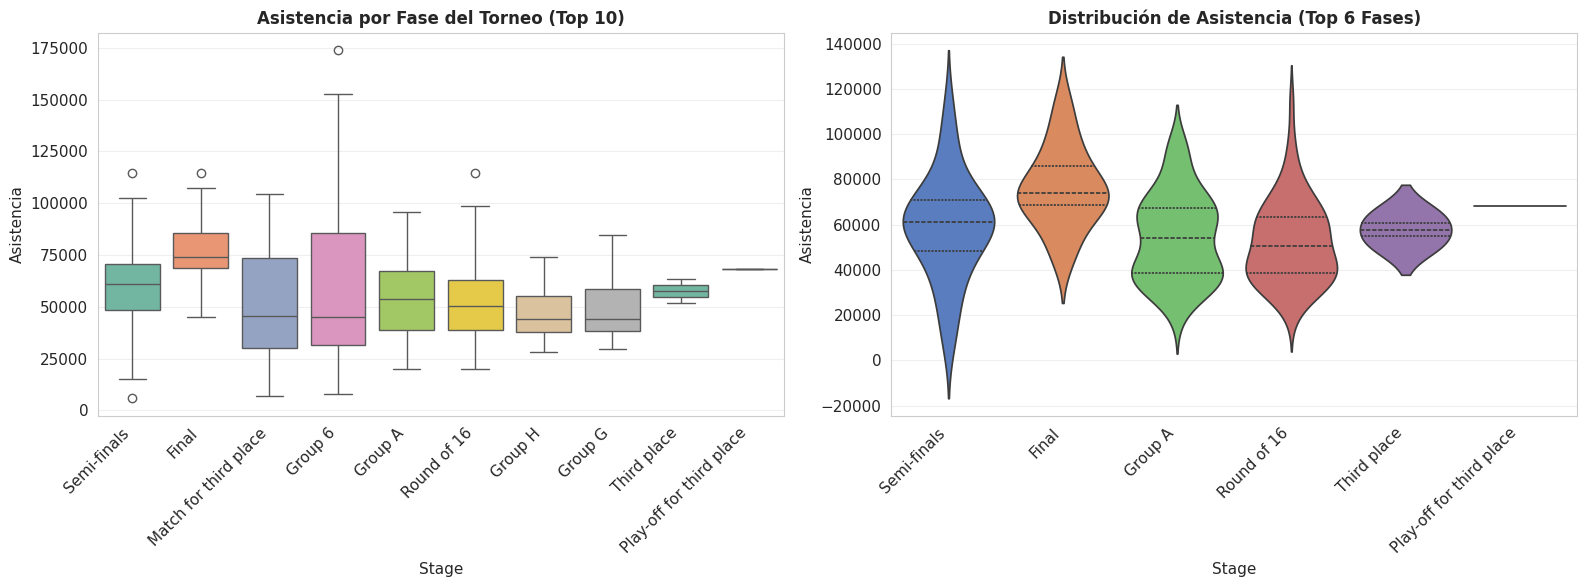

In [23]:
# Asistencia por fase del torneo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot por Stage
stage_order = df_clean.groupby("Stage")["Attendance"].median().sort_values(ascending=False).head(10).index
sns.boxplot(data=df_clean[df_clean["Stage"].isin(stage_order)], 
            x="Stage", y="Attendance", ax=axes[0], palette="Set2")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("Asistencia por Fase del Torneo (Top 10)", fontweight='bold', fontsize=12)
axes[0].set_ylabel("Asistencia")
axes[0].grid(True, alpha=0.3, axis='y')

# Violin plot por Stage (Top 6)
top6_stages = stage_order[:6]
sns.violinplot(data=df_clean[df_clean["Stage"].isin(top6_stages)], 
               x="Stage", y="Attendance", ax=axes[1], palette="muted", inner="quartile")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("Distribución de Asistencia (Top 6 Fases)", fontweight='bold', fontsize=12)
axes[1].set_ylabel("Asistencia")
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


#### -Casi todas las fases (Semi-finals, Match for third place, Group 6, Group A, Round of 16, Group H) presentan círculos (outliers) por encima de sus bigotes. Esto significa que en casi todas las fases hay partidos excepcionales con asistencia muy alta (cercana o superior a 100,000).
#### En el boxplot, las fases como Group A, Group G, Group H tienen rangos amplios y outliers, esto refleja que algunos partidos de grupos se juegan en estadios muy grandes y otros en más pequeños, también hay valores bajos (< 30.000), posiblemente en sedes con menor capacidad o partidos con equipos menos populares.
#### En el violin plot, la forma estrecha en las fases finales indica que la asistencia se concentra en un rango alto y estable (poca dispersión), en contraste, las fases de grupos tienen violines más anchos l que significa mayor dispersión de valores.

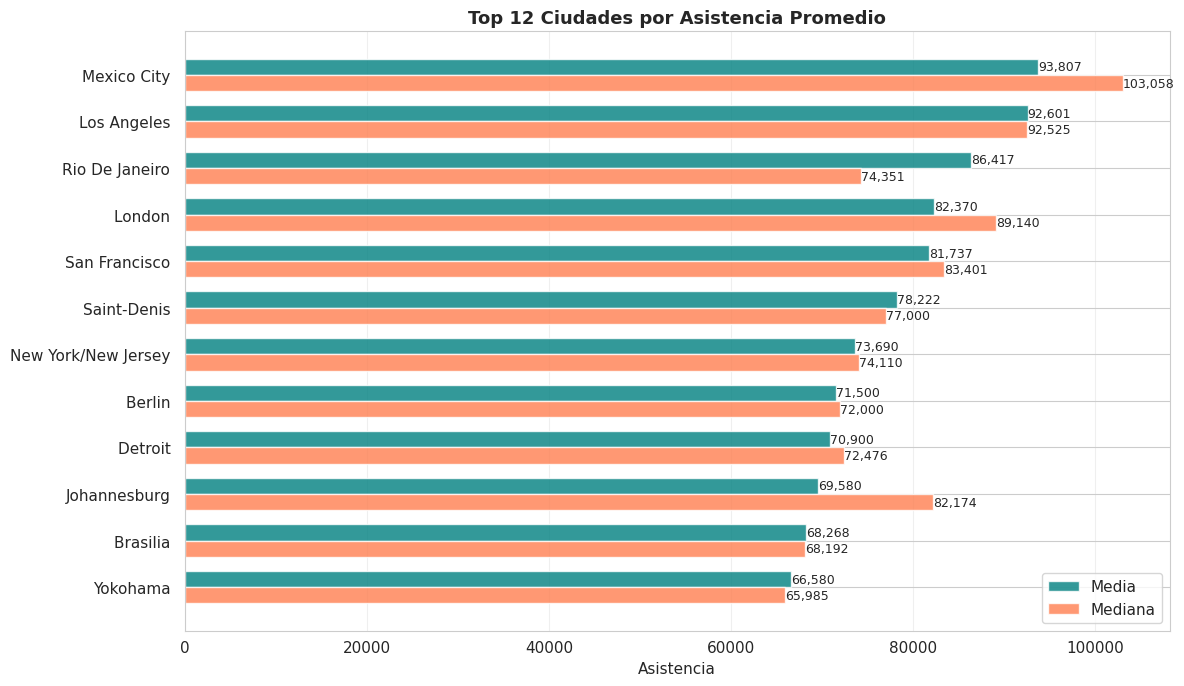

In [24]:
# Top ciudades por asistencia
top_cities = df_clean.groupby("City").agg({
    'Attendance': ['mean', 'median', 'count']
}).round(0)
top_cities.columns = ['Media', 'Mediana', 'N° Partidos']
top_cities = top_cities.sort_values('Media', ascending=False).head(12)

fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(top_cities))
width = 0.35

bars1 = ax.barh(x - width/2, top_cities['Media'], width, label='Media', color='teal', alpha=0.8)
bars2 = ax.barh(x + width/2, top_cities['Mediana'], width, label='Mediana', color='coral', alpha=0.8)

ax.set_yticks(x)
ax.set_yticklabels(top_cities.index)
ax.invert_yaxis()
ax.set_xlabel('Asistencia')
ax.set_title('Top 12 Ciudades por Asistencia Promedio', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

# Agregar valores en las barras
for bars in [bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{int(width):,}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

#### En general, la similitud entre la media y la mediana en la mayoría de las sedes sugiere que la asistencia fue estable, aunque algunas ciudades (como México City) destacan por picos de afluencia excepcionales que elevan su promedio global

# Visualizaciones Bivariadas y Multivariadas

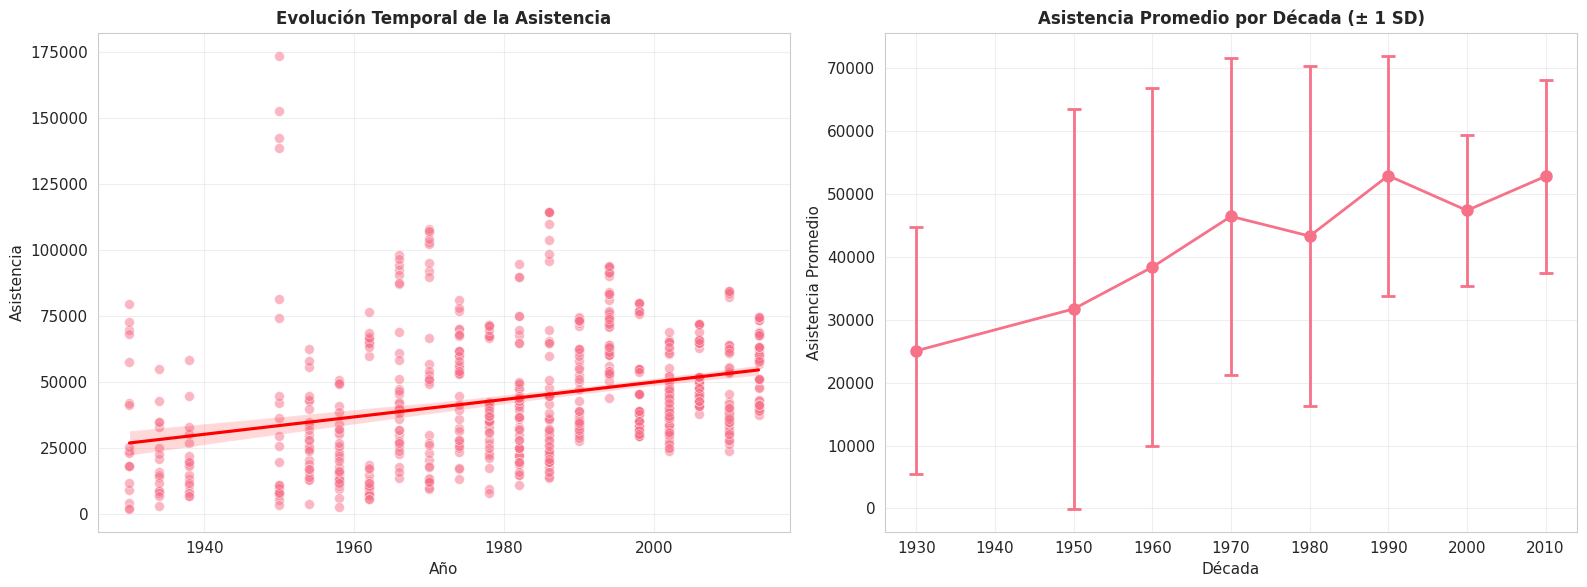

In [25]:
# Dispersión: Year vs Attendance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter con tendencia
sns.scatterplot(data=df_clean, x="Year", y="Attendance", alpha=0.5, s=50, ax=axes[0])
sns.regplot(data=df_clean, x="Year", y="Attendance", scatter=False, color='red', ax=axes[0])
axes[0].set_title("Evolución Temporal de la Asistencia", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Año")
axes[0].set_ylabel("Asistencia")
axes[0].grid(True, alpha=0.3)

# Promedio por década
df_clean['Decada'] = (df_clean['Year'] // 10) * 10
decade_stats = df_clean.groupby('Decada')['Attendance'].agg(['mean', 'std'])
axes[1].errorbar(decade_stats.index, decade_stats['mean'], yerr=decade_stats['std'], 
                 marker='o', markersize=8, linewidth=2, capsize=5, capthick=2)
axes[1].set_title("Asistencia Promedio por Década (± 1 SD)", fontweight='bold', fontsize=12)
axes[1].set_xlabel("Década")
axes[1].set_ylabel("Asistencia Promedio")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### -La línea de regresión indica que, con el paso de los años, la asistencia promedio por partido ha aumentado.
#### En la gráfica por década, se nota un salto significativo entre las décadas de 1950 y 1970, alcanzando medias cercanas a los 50.000 asistentes
#### Entre 1970 y 2010, el promedio se mantiene entre 50.000 y 60.000 asistentes, sin grandes caídas


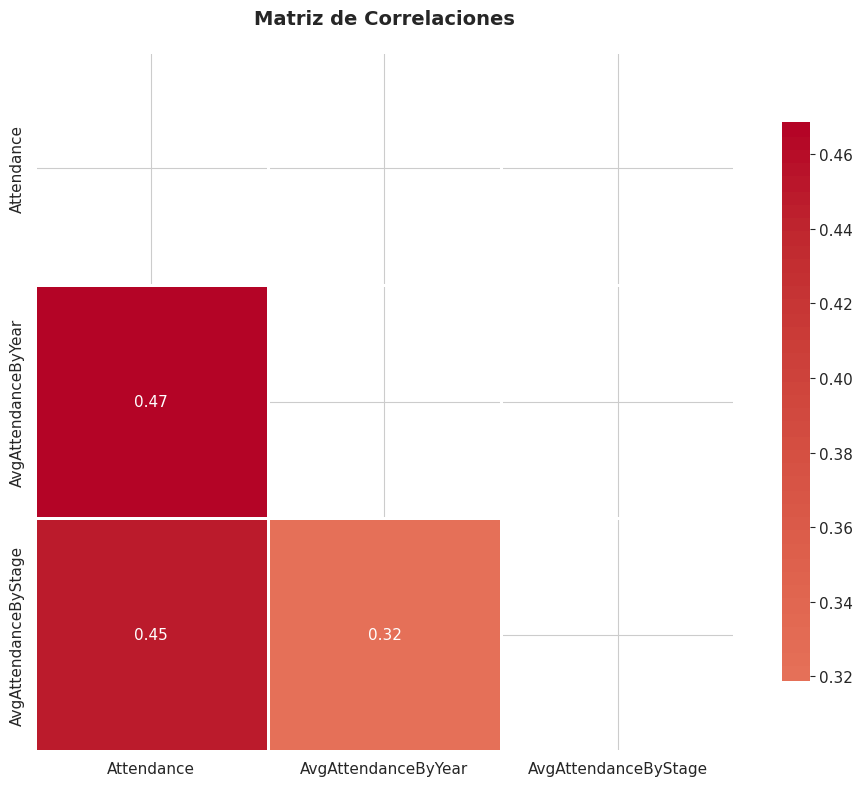

In [28]:
# Matriz de correlaciones
corr_matrix = df_clean[vars_continuas].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title("Matriz de Correlaciones", fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


#### La matriz de correlación muestra que las asistencias por partido están moderadamente relacionadas con las tendencias anuales y por etapa, sin redundar completamente entre sí

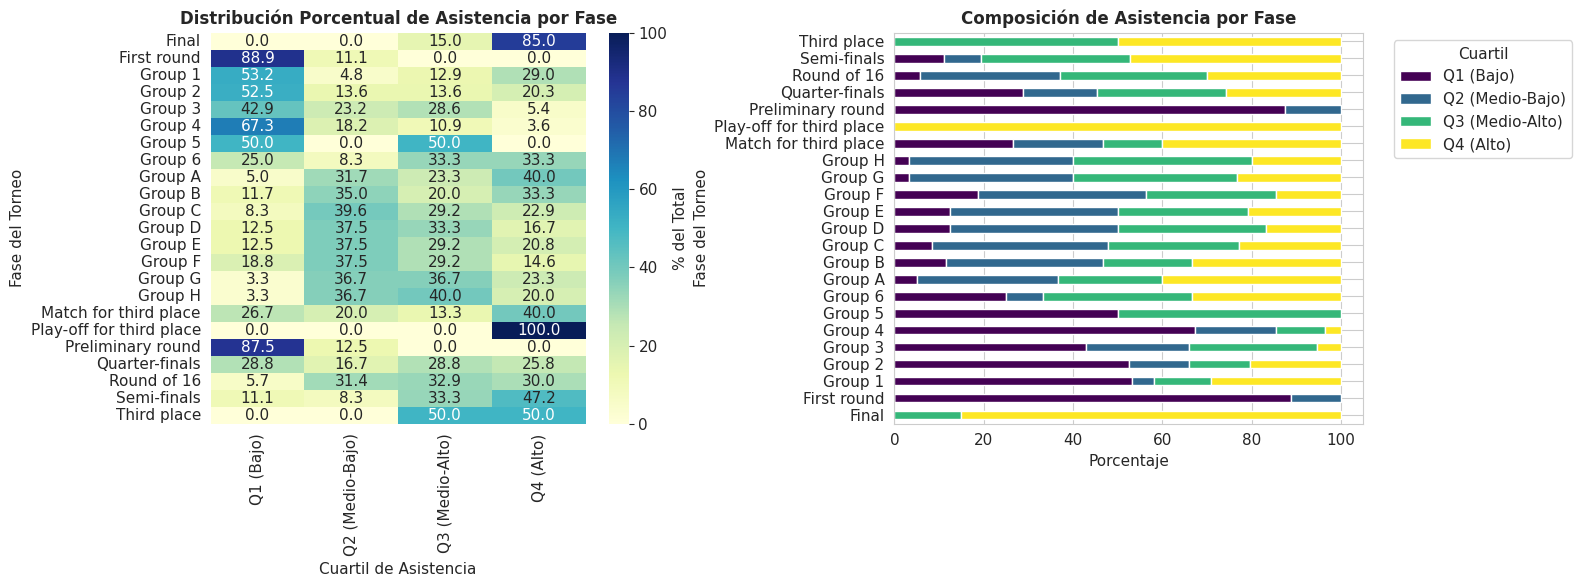

In [32]:
# Análisis cruzado: Stage vs Cuartiles de Attendance
df_clean["Attendance_Quartile"] = pd.qcut(df_clean["Attendance"], q=4, 
                                           labels=["Q1 (Bajo)", "Q2 (Medio-Bajo)", 
                                                   "Q3 (Medio-Alto)", "Q4 (Alto)"],
                                           duplicates="drop")

cross_tab = pd.crosstab(df_clean["Stage"], df_clean["Attendance_Quartile"], normalize="index") * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
sns.heatmap(cross_tab, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[0], 
            cbar_kws={'label': '% del Total'})
axes[0].set_title("Distribución Porcentual de Asistencia por Fase", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Cuartil de Asistencia")
axes[0].set_ylabel("Fase del Torneo")

# Barras apiladas
cross_tab.plot(kind='barh', stacked=True, ax=axes[1], colormap='viridis')
axes[1].set_title("Composición de Asistencia por Fase", fontweight='bold', fontsize=12)
axes[1].set_xlabel("Porcentaje")
axes[1].set_ylabel("Fase del Torneo")
axes[1].legend(title='Cuartil', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

#### Se ve más claramente cómo las fases finales (especialmente Final y Semi-finals) están dominadas por el color amarillo (Q4 = alta asistencia), en cambio, las primeras fases (grupos y rondas preliminares) tienen una mezcla de azul oscuro y celeste (Q1 y Q2)

### Principales Descubrimientos:

1. **Distribución de Asistencia:**
   - La asistencia promedio es significativamente alta, con gran variabilidad entre partidos
   - La distribución muestra asimetría positiva con presencia de valores extremos
   - El test de normalidad confirma que NO sigue distribución normal

2. **Evolución Temporal:**
   - Tendencia creciente de asistencia desde 1930 hasta la actualidad
   - Picos importantes en décadas recientes (1990-2010)
   - El crecimiento refleja la expansión del torneo y mejora de infraestructura

3. **Impacto de la Fase del Torneo:**
   - Fases finales (semifinales, final) concentran mayor asistencia
   - Fase de grupos presenta mayor variabilidad en asistencia
   - Diferencia significativa entre fases eliminatorias y de grupos

4. **Ciudades Sede:**
   - Las ciudades más grandes tienden a tener mayor asistencia promedio
   - Variabilidad considerable entre ciudades en un mismo torneo
   - Factores como capacidad del estadio y ubicación son determinantes

5. **Relación con Variables Deportivas:**
   - Correlación baja/moderada entre goles y asistencia (0.2-0.3)
   - La asistencia no depende fuertemente del resultado deportivo
   - Las variables derivadas (promedios por año/etapa) muestran alta correlación con asistencia
"""

# Detección de Valores Atípicos
### Metodología:
Se aplicarán dos técnicas complementarias para identificar outliers:

1. **Método IQR (Rango Intercuartílico):** Enfoque univariado sobre la variable Attendance
2. **DBSCAN (Density-Based Spatial Clustering):** Enfoque multivariado considerando múltiples variables
"""

In [42]:
# Técnica 1: Detección con IQR
att = df_clean["Attendance"].dropna()
Q1, Q3 = att.quantile(0.25), att.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean["outlier_iqr"] = (df_clean["Attendance"] < lower_bound) | (df_clean["Attendance"] > upper_bound)

n_outliers_iqr = df_clean["outlier_iqr"].sum()
pct_outliers_iqr = (n_outliers_iqr / len(df_clean)) * 100

print("="*60)
print("DETECCIÓN DE ATÍPICOS: MÉTODO IQR")
print("="*60)
print(f"Q1 (25%): {Q1:,.0f}")
print(f"Q3 (75%): {Q3:,.0f}")
print(f"IQR: {IQR:,.0f}")
print(f"Límite inferior: {lower_bound:,.0f}")
print(f"Límite superior: {upper_bound:,.0f}")
print(f"\n✓ Atípicos detectados: {n_outliers_iqr} ({pct_outliers_iqr:.2f}%)")
print("="*60)


DETECCIÓN DE ATÍPICOS: MÉTODO IQR
Q1 (25%): 30,000
Q3 (75%): 61,374
IQR: 31,374
Límite inferior: -17,062
Límite superior: 108,436

✓ Atípicos detectados: 10 (1.18%)


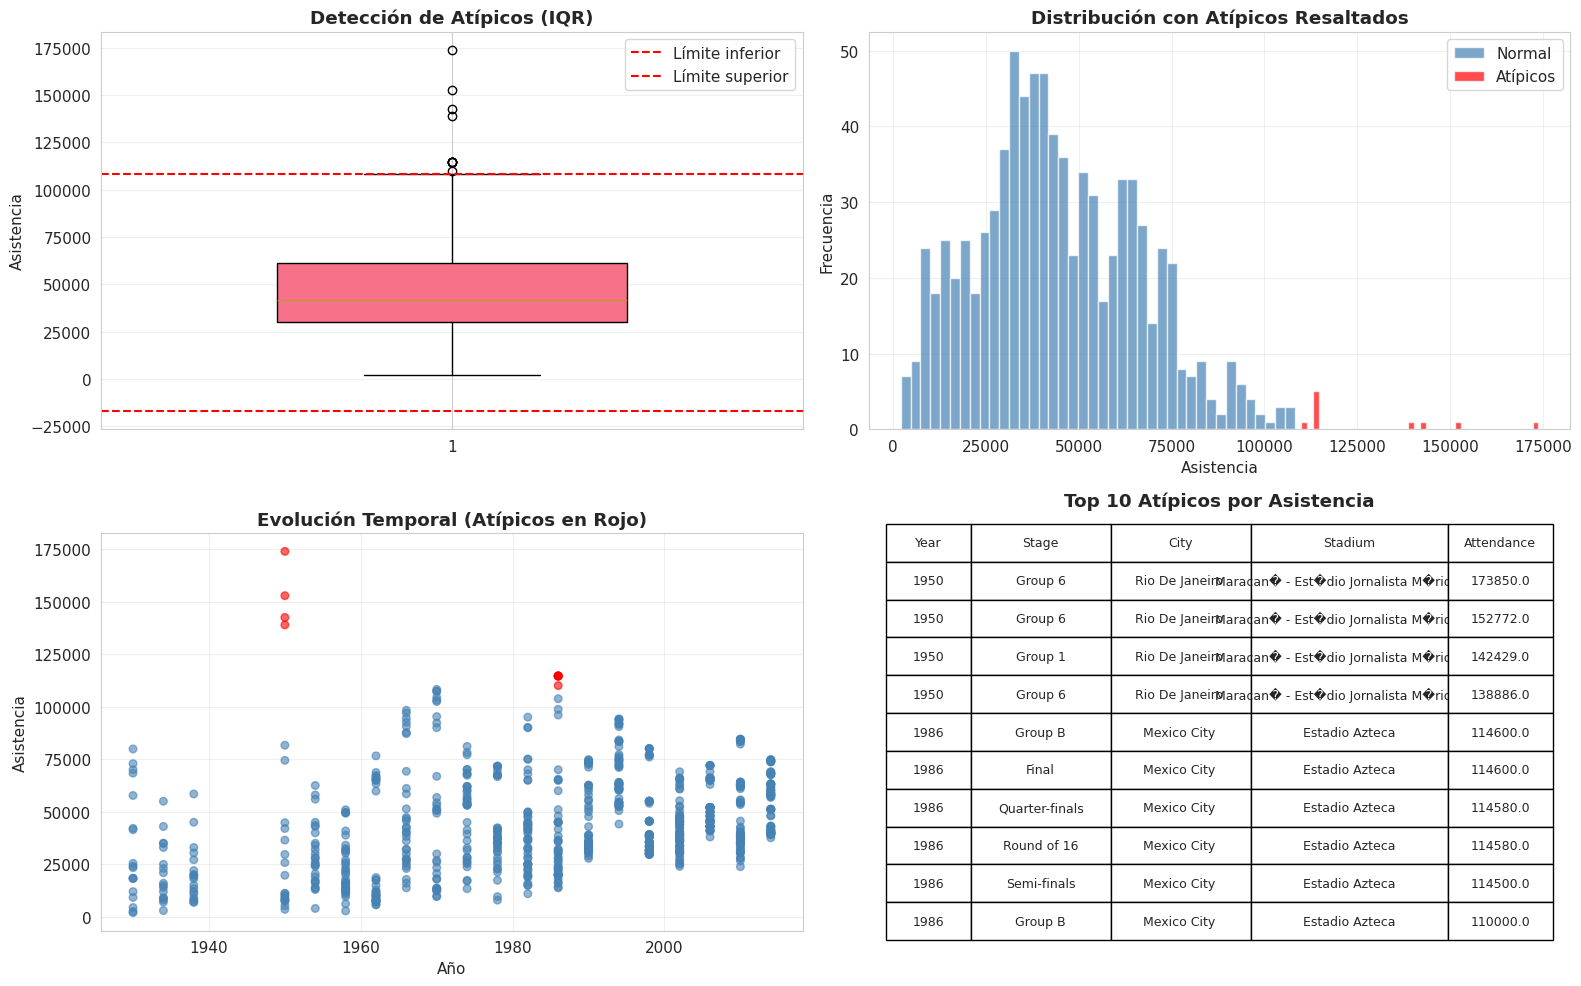

In [34]:
# Visualización de outliers IQR
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Boxplot con outliers marcados
axes[0, 0].boxplot(df_clean["Attendance"], vert=True, patch_artist=True, widths=0.5)
axes[0, 0].axhline(lower_bound, color='red', linestyle='--', label='Límite inferior')
axes[0, 0].axhline(upper_bound, color='red', linestyle='--', label='Límite superior')
axes[0, 0].set_ylabel("Asistencia")
axes[0, 0].set_title("Detección de Atípicos (IQR)", fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Histograma con outliers resaltados
axes[0, 1].hist(df_clean[~df_clean["outlier_iqr"]]["Attendance"], bins=40, 
                color='steelblue', alpha=0.7, label='Normal')
axes[0, 1].hist(df_clean[df_clean["outlier_iqr"]]["Attendance"], bins=40, 
                color='red', alpha=0.7, label='Atípicos')
axes[0, 1].set_xlabel("Asistencia")
axes[0, 1].set_ylabel("Frecuencia")
axes[0, 1].set_title("Distribución con Atípicos Resaltados", fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter temporal con outliers
colors = df_clean["outlier_iqr"].map({False: 'steelblue', True: 'red'})
axes[1, 0].scatter(df_clean["Year"], df_clean["Attendance"], c=colors, alpha=0.6, s=30)
axes[1, 0].set_xlabel("Año")
axes[1, 0].set_ylabel("Asistencia")
axes[1, 0].set_title("Evolución Temporal (Atípicos en Rojo)", fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Top 10 outliers
top_outliers = df_clean[df_clean["outlier_iqr"]].nlargest(10, "Attendance")[
    ["Year", "Stage", "City", "Stadium", "Attendance"]
]
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=top_outliers.values, 
                         colLabels=top_outliers.columns,
                         cellLoc='center', loc='center',
                         colWidths=[0.12, 0.2, 0.2, 0.28, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
axes[1, 1].set_title("Top 10 Atípicos por Asistencia", fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


In [40]:
# Técnica 2: DBSCAN (multivariado)
features = ["Attendance", "Home Team Goals", "Away Team Goals", 
            "Half-time Home Goals", "Half-time Away Goals"]
df_features = df_clean[features].dropna()
feature_idx = df_features.index

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

# Parámetros DBSCAN optimizados
min_samples = max(15, int(0.01 * len(df_features)))
eps = 1.5

# Aplicar DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean")
labels = dbscan.fit_predict(X_scaled)

# Marcar outliers
df_clean["outlier_dbscan"] = False
df_clean.loc[feature_idx, "outlier_dbscan"] = (labels == -1)

n_outliers_db = (labels == -1).sum()
pct_outliers_db = (n_outliers_db / len(df_clean)) * 100
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

print("="*60)
print("DETECCIÓN DE ATÍPICOS: MÉTODO DBSCAN")
print("="*60)
print(f"Parámetros: eps={eps}, min_samples={min_samples}")
print(f"Variables: {', '.join(features)}")
print(f"\n✓ Clusters identificados: {n_clusters}")
print(f"✓ Atípicos detectados: {n_outliers_db} ({pct_outliers_db:.2f}%)")
print("="*60)

DETECCIÓN DE ATÍPICOS: MÉTODO DBSCAN
Parámetros: eps=1.5, min_samples=15
Variables: Attendance, Home Team Goals, Away Team Goals, Half-time Home Goals, Half-time Away Goals

✓ Clusters identificados: 1
✓ Atípicos detectados: 42 (4.94%)


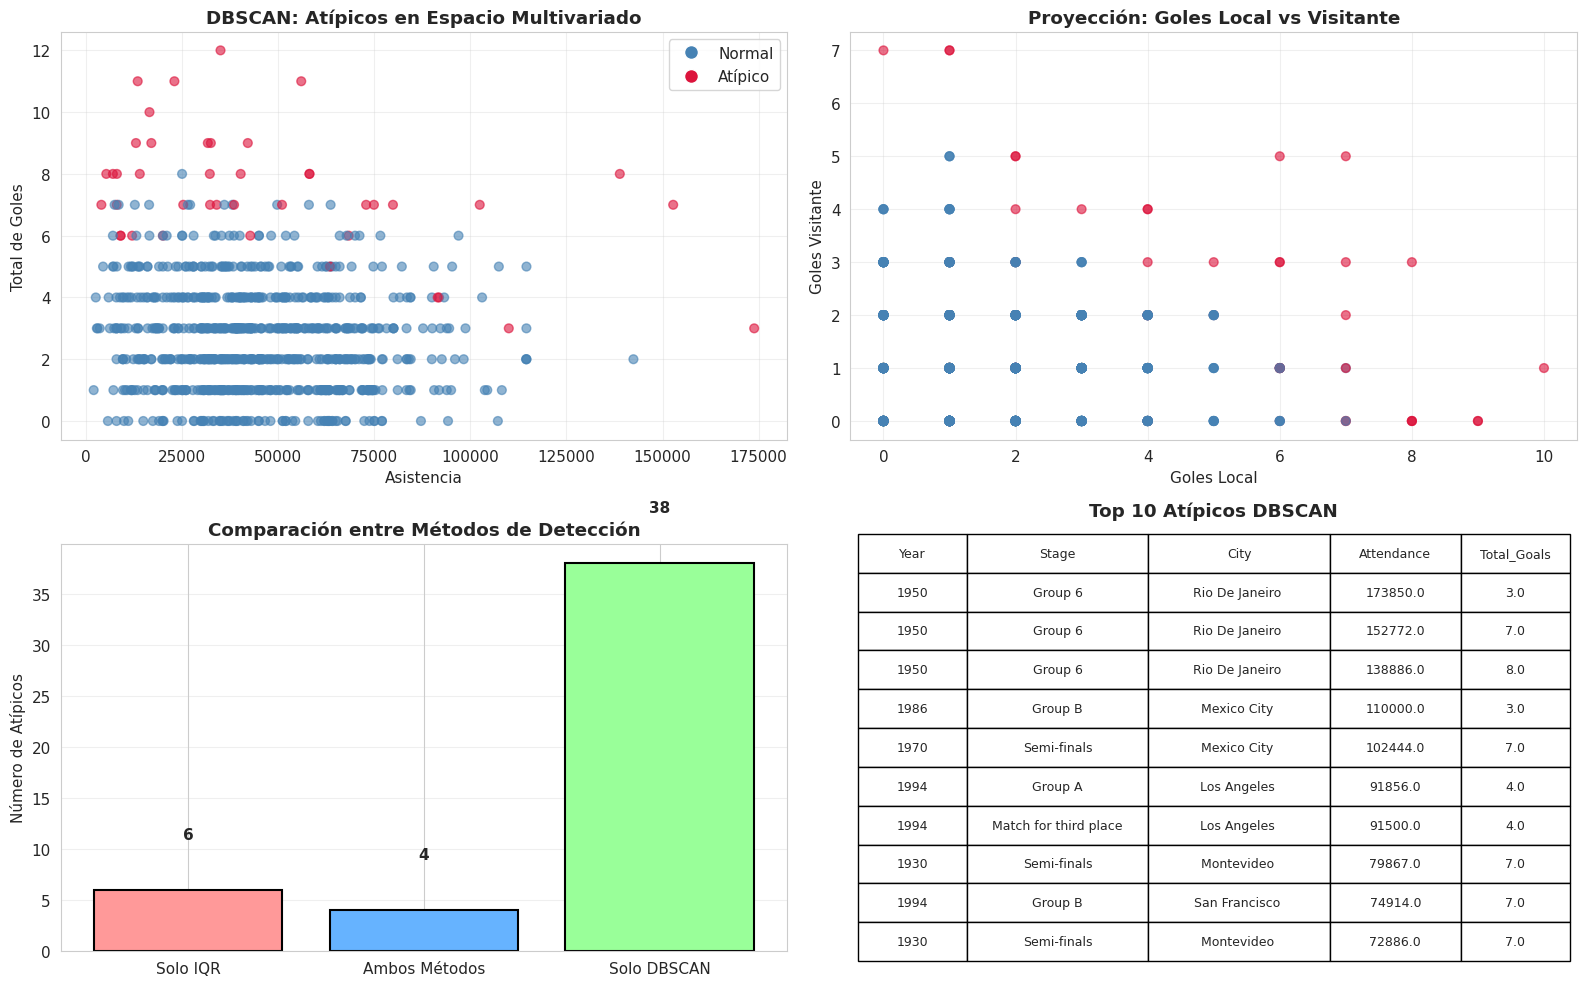


Intersección entre métodos: 4 registros detectados por ambos


In [44]:
# Visualización DBSCAN
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Scatter 2D: Attendance vs Goals
colors_db = df_clean["outlier_dbscan"].map({False: 'steelblue', True: 'crimson'})
axes[0, 0].scatter(df_clean["Attendance"], df_clean["Total_Goals"], 
                   c=colors_db, alpha=0.6, s=40)
axes[0, 0].set_xlabel("Asistencia")
axes[0, 0].set_ylabel("Total de Goles")
axes[0, 0].set_title("DBSCAN: Atípicos en Espacio Multivariado", fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='Normal'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='crimson', markersize=10, label='Atípico')
])

# Scatter 3D proyectado
axes[0, 1].scatter(df_clean["Home Team Goals"], df_clean["Away Team Goals"], 
                   c=colors_db, alpha=0.6, s=40)
axes[0, 1].set_xlabel("Goles Local")
axes[0, 1].set_ylabel("Goles Visitante")
axes[0, 1].set_title("Proyección: Goles Local vs Visitante", fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Comparación entre métodos
venn_data = pd.DataFrame({
    'IQR': df_clean["outlier_iqr"],
    'DBSCAN': df_clean["outlier_dbscan"]
})
both = (venn_data['IQR'] & venn_data['DBSCAN']).sum()
only_iqr = (venn_data['IQR'] & ~venn_data['DBSCAN']).sum()
only_dbscan = (~venn_data['IQR'] & venn_data['DBSCAN']).sum()

categories = ['Solo IQR', 'Ambos Métodos', 'Solo DBSCAN']
values = [only_iqr, both, only_dbscan]
colors_venn = ['#ff9999', '#66b3ff', '#99ff99']

axes[1, 0].bar(categories, values, color=colors_venn, edgecolor='black', linewidth=1.5)
axes[1, 0].set_ylabel("Número de Atípicos")
axes[1, 0].set_title("Comparación entre Métodos de Detección", fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(values):
    axes[1, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Top outliers DBSCAN
top_outliers_db = df_clean[df_clean["outlier_dbscan"]].nlargest(10, "Attendance")[
    ["Year", "Stage", "City", "Attendance", "Total_Goals"]
]
axes[1, 1].axis('tight')
axes[1, 1].axis('off')
table = axes[1, 1].table(cellText=top_outliers_db.values, 
                         colLabels=top_outliers_db.columns,
                         cellLoc='center', loc='center',
                         colWidths=[0.15, 0.25, 0.25, 0.18, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
axes[1, 1].set_title("Top 10 Atípicos DBSCAN", fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"\nIntersección entre métodos: {both} registros detectados por ambos")


#### -La mayoría de partidos están concentrados en marcadores bajos (0–3 goles por equipo), los puntos rojos (atípicos) son partidos con resultados inusuales: por ejemplo, 8–0, 7–1 o marcadores muy altos que son raros en mundiales.
#### -DBSCAN detecta muchos más outliers que IQR, probablemente porque considera la relación conjunta entre variables (Attendance y Goals), no solo un rango estadístico univariado el IQR es más conservador: detecta pocos valores extremos basándose en los cuartiles de cada variable individual.
#### -Los partidos atípicos suelen compartir dos características: 
##### Altísima asistencia (estadios monumentales o finales históricas).
##### Marcadores inusualmente altos (juegos muy abiertos o desbalanceados).


In [50]:
output_outliers_iqr = DATA_DIR / "outliers_iqr.csv"
output_outliers_dbscan = DATA_DIR / "outliers_dbscan.csv"


df_clean[df_clean["outlier_iqr"]].to_csv(output_outliers_iqr, index=False)
df_clean[df_clean["outlier_dbscan"]].to_csv(output_outliers_dbscan, index=False)

print(f"  - {output_outliers_iqr}")
print(f"  - {output_outliers_dbscan}")

  - ../data/outliers_iqr.csv
  - ../data/outliers_dbscan.csv
